In [1]:
# Dependancies

# Data manipulation
import numpy as np
import pandas as pd

# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Time Series
from statsmodels.tsa.arima_model import ARIMA

## Load data

In [2]:
# Load dataset
df = pd.read_csv('../input/absenteeism-at-work-uci-ml-repositiory/Absenteeism_at_work.csv', sep=';')

In [3]:
# Rename colums - Kerstin Wagner [1]
df.rename(columns={
    'Reason for absence': 'Reason',
    'Month of absence': 'Month',
    'Day of the week': 'Weekday',
    'Seasons': 'Season',
    'Disciplinary failure': 'Failure',
    'Transportation expense': 'Expense',
    'Distance from Residence to Work': 'Distance',
    'Service time': 'ServiceTime',
    'Work load Average/day ': 'Workload',
    'Hit target': 'HitTarget',
    'Son': 'Child',
    'Social drinker': 'Drinker',
    'Social smoker': 'Smoker',
    'Body mass index': 'BMI',
    'Absenteeism time in hours': 'AbsH'}, 
    inplace = True)

In [4]:
# Set attributes as category
cat_attributes = ['ID', 'Reason', 'Month', 'Weekday', 'Season', 'Education', 'Failure', 'Drinker', 'Smoker']
for att in cat_attributes:
    df[att] = df[att].astype('category')

## EDA

In [5]:
# Missing data
df.isna().apply(sum)

ID             0
Reason         0
Month          0
Weekday        0
Season         0
Expense        0
Distance       0
ServiceTime    0
Age            0
Workload       0
HitTarget      0
Failure        0
Education      0
Child          0
Drinker        0
Smoker         0
Pet            0
Weight         0
Height         0
BMI            0
AbsH           0
dtype: int64

In [6]:
# Numeric variables description
df.describe(include=np.number)

,Expense,Distance,ServiceTime,Age,Workload,HitTarget,Child,Pet,Weight,Height,BMI,AbsH
count,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000
mean,221.329730,29.631081,12.554054,36.450000,271.490235,94.587838,1.018919,0.745946,79.035135,172.114865,26.677027,6.924324
std,66.952223,14.836788,4.384873,6.478772,39.058116,3.779313,1.098489,1.318258,12.883211,6.034995,4.285452,13.330998
min,118.000000,5.000000,1.000000,27.000000,205.917000,81.000000,0.000000,0.000000,56.000000,163.000000,19.000000,0.000000
25%,179.000000,16.000000,9.000000,31.000000,244.387000,93.000000,0.000000,0.000000,69.000000,169.000000,24.000000,2.000000
50%,225.000000,26.000000,13.000000,37.000000,264.249000,95.000000,1.000000,0.000000,83.000000,170.000000,25.000000,3.000000
75%,260.000000,50.000000,16.000000,40.000000,294.217000,97.000000,2.000000,1.000000,89.000000,172.000000,31.000000,8.000000
max,388.000000,52.000000,29.000000,58.000000,378.884000,100.000000,4.000000,8.000000,108.000000,196.000000,38.000000,120.000000


In [7]:
# Categorical variables description
df.describe(include='category')

,ID,Reason,Month,Weekday,Season,Failure,Education,Drinker,Smoker
count,740,740,740,740,740,740,740,740,740
unique,36,28,13,5,4,2,4,2,2
top,3,23,3,2,4,0,1,1,0
freq,113,149,87,161,195,700,611,420,686


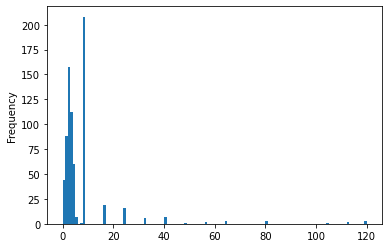

In [8]:
# Hist of AbsH
df['AbsH'].plot(kind='hist', bins=120);

In [9]:
# People
pot_personal_attributes = ['ID', 'Expense', 'Distance', 'ServiceTime', 'Age', 'Education', 'Child', 'Drinker', 'Smoker', 'Pet', 'Weight', 'Height', 'BMI', 'Failure']

personal_attributes_count = df.groupby('ID')[pot_personal_attributes].nunique() == 1

def mapcol(val):
    col = 'green' if val else 'red'
    return f'background-color: {col}'

personal_attributes_count.style.applymap(mapcol)

,ID,Expense,Distance,ServiceTime,Age,Education,Child,Drinker,Smoker,Pet,Weight,Height,BMI,Failure
ID,,,,,,,,,,,,,,
1,True,True,True,True,True,True,True,True,True,True,True,True,True,False
2,True,True,True,True,True,True,True,True,True,True,True,True,True,False
3,True,True,True,True,True,True,True,True,True,True,True,True,True,False
4,True,True,True,True,True,True,True,True,True,True,True,True,True,True
5,True,True,True,True,True,True,True,True,True,True,True,True,True,False
6,True,True,True,True,True,True,True,True,True,True,True,True,True,True
7,True,True,True,True,True,True,True,True,True,True,True,True,True,False
8,True,True,True,True,True,True,True,True,True,True,True,True,True,False
9,True,True,True,True,True,True,True,True,True,True,True,True,True,True


In [10]:
# Let's take a closer look at number 29
df[df['ID'] == 29][pot_personal_attributes]

,ID,Expense,Distance,ServiceTime,Age,Education,Child,Drinker,Smoker,Pet,Weight,Height,BMI,Failure
51,29,225,26,9,28,1,1,0,0,2,69,169,24,1
592,29,225,15,15,41,4,2,1,0,2,94,182,28,0
675,29,225,15,15,41,4,2,1,0,2,94,182,28,0
681,29,225,15,15,41,4,2,1,0,2,94,182,28,0
683,29,225,15,15,41,4,2,1,0,2,94,182,28,0


IMPORTANT: It's seems that two differents people used ID 29 !

## Data Cleaning

In [11]:
# Study context -- short absences

# Delete absence of more than 3 days
df = df[df['AbsH'] <= 24]

In [12]:
# Employee data 

# Delete 29
employees = df[df['ID'] != 29]

# Get personal attributes
personal_attributes = ['ID', 'Expense', 'Distance', 'ServiceTime', 'Age', 'Education', 'Child', 'Drinker', 'Smoker', 'Pet', 'Weight', 'Height', 'BMI']
employees = employees[personal_attributes]

# Delete dupliactes
employees = employees.drop_duplicates().set_index('ID')

In [13]:
# Absence records

# Get absence attributes
record_attributes = ['ID', 'AbsH', 'Failure', 'HitTarget', 'Month', 'Reason', 'Season', 'Weekday', 'Workload']
absences = df[record_attributes]

# Delete recors with unvalid values

# Invalid Month
absences = absences[absences['Month'].isin(range(1, 12+1))]

# Invalid Reason
absences = absences[absences['Reason'].isin(range(1, 28+1))]

In [14]:
# Add absenteeism information to employees

employees['AbsNumber'] = 0
employees['AbsTime'] = 0

for _, row in absences.iterrows():
    if row['ID'] in employees.index:
        employees.loc[row['ID'], 'AbsNumber'] += 1
        employees.loc[row['ID'], 'AbsTime'] += row['AbsH']

## Data Analysis

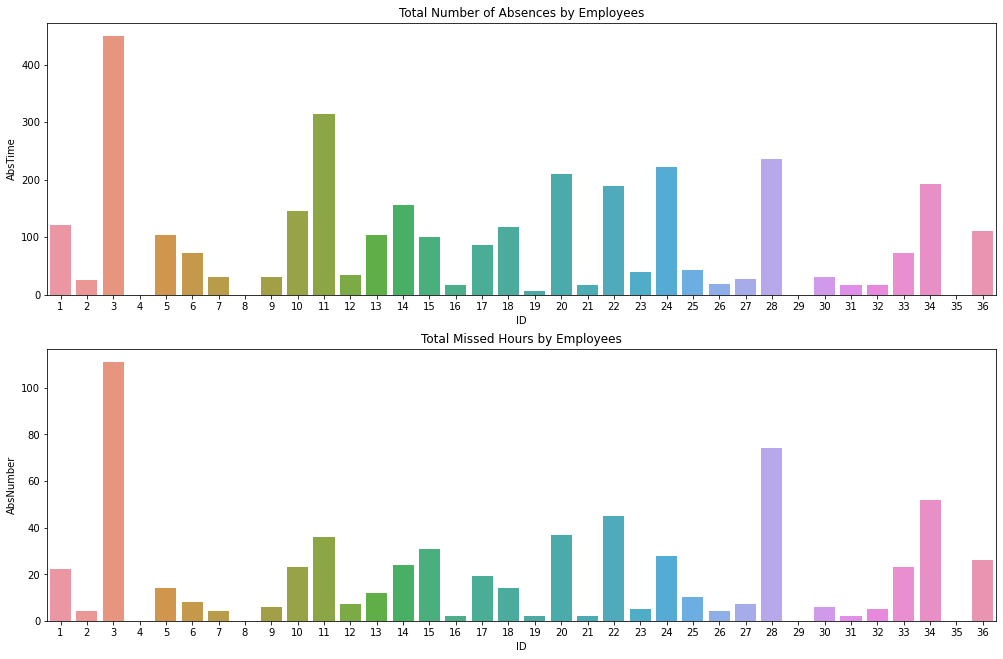

In [15]:
# Total number and time of absences
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(17, 11))
ax1.title.set_text('Total Number of Absences by Employees')
ax2.title.set_text('Total Missed Hours by Employees')
sns.barplot(x=employees.index, y=employees['AbsTime'], ax=ax1)
sns.barplot(x=employees.index, y=employees['AbsNumber'], ax=ax2);

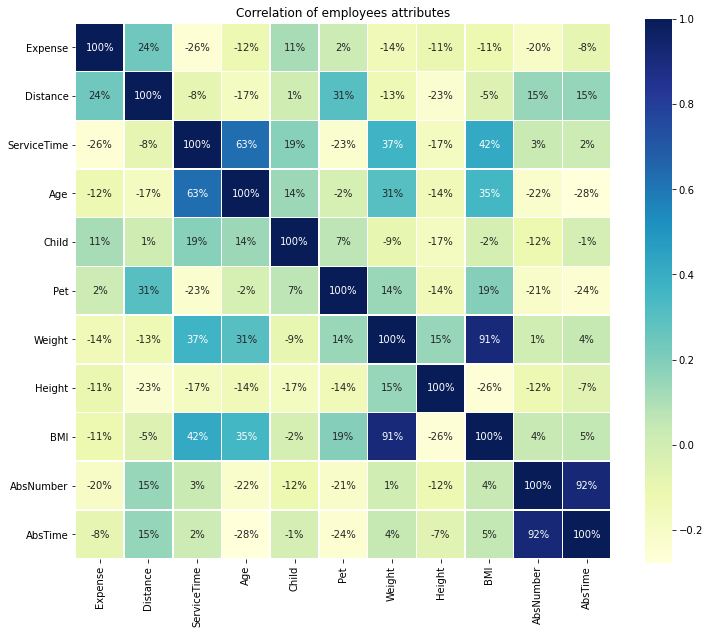

In [16]:
# Correlation
plt.figure(figsize=(12, 10))
plt.title('Correlation of employees attributes')
sns.heatmap(employees.corr(), annot=True, cmap="YlGnBu", fmt='.0%', square=True, linewidths =.5);

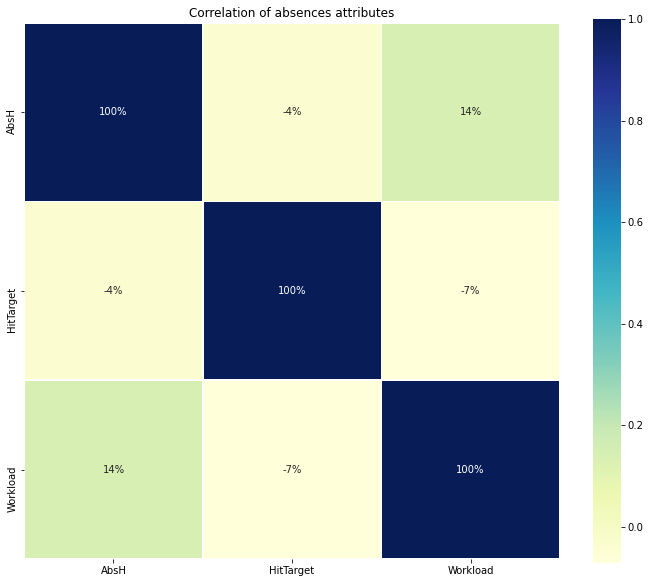

In [17]:
# Correlation
plt.figure(figsize=(12, 10))
plt.title('Correlation of absences attributes')
sns.heatmap(absences.corr(), annot=True, cmap="YlGnBu", fmt='.0%', square=True, linewidths =.5);

### Reason

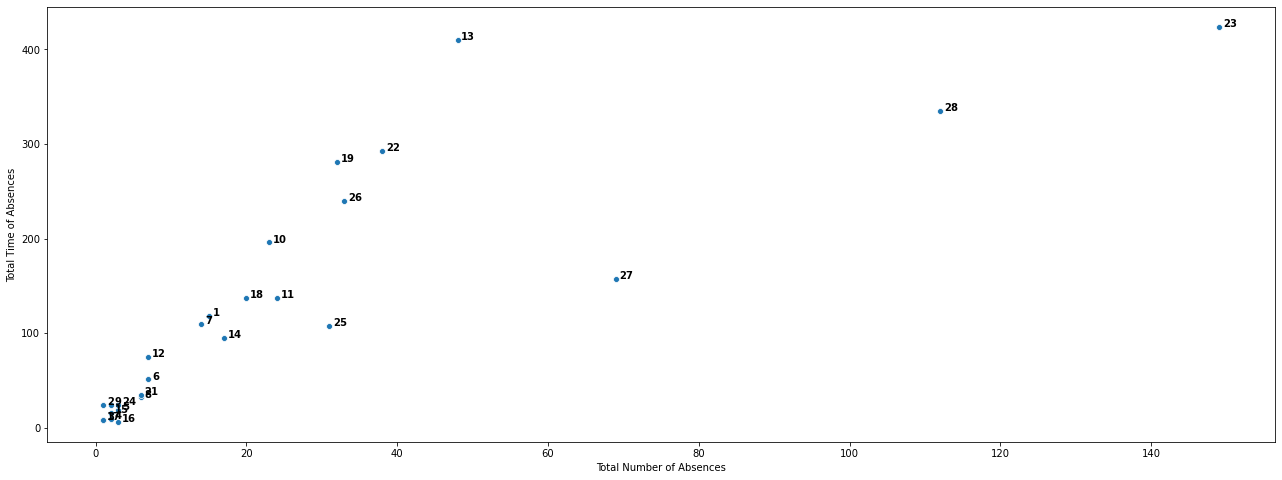

In [18]:
# Scatter plot
plt.figure(figsize=(22, 8))

groups = absences.groupby('Reason')['AbsH']
number = groups.apply(len).iloc[1:]
time = groups.sum().iloc[1:]

p = sns.scatterplot(x=number, y=time)

for i in number.index:
        p.text(number.loc[i]+0.5, time.loc[i], i, size='medium', weight='semibold')
    
p.set_ylabel('Total Time of Absences')
p.set_xlabel('Total Number of Absences');

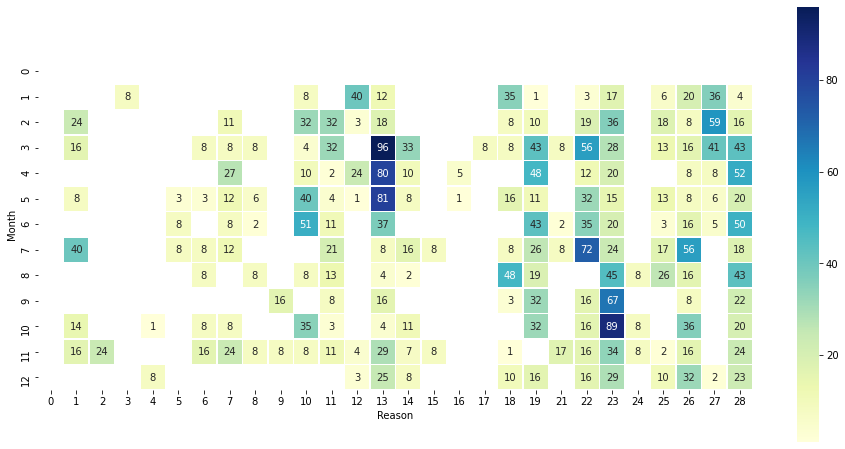

In [19]:
# Reason & Time
plt.figure(figsize=(16, 8))
sns.heatmap(absences.groupby(['Month', 'Reason'])['AbsH'].sum().unstack(), annot=True, cmap="YlGnBu", square=True, linewidths =.5);

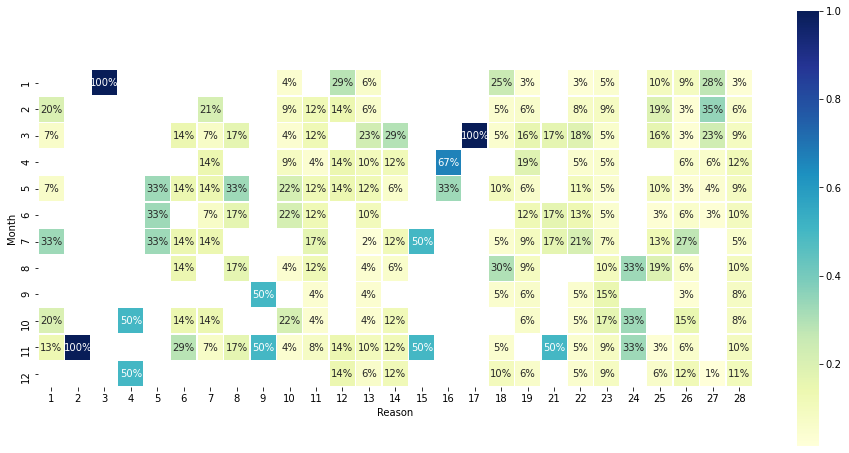

In [20]:
# Reason & Number
plt.figure(figsize=(16, 8))
data = absences.groupby(['Month', 'Reason']).apply(len) / absences.groupby('Reason').apply(len)
data = data.unstack()
data = data.loc[:, sorted(data.columns)]
sns.heatmap(data, annot=True, cmap="YlGnBu", square=True, linewidths =.5, fmt='.0%');

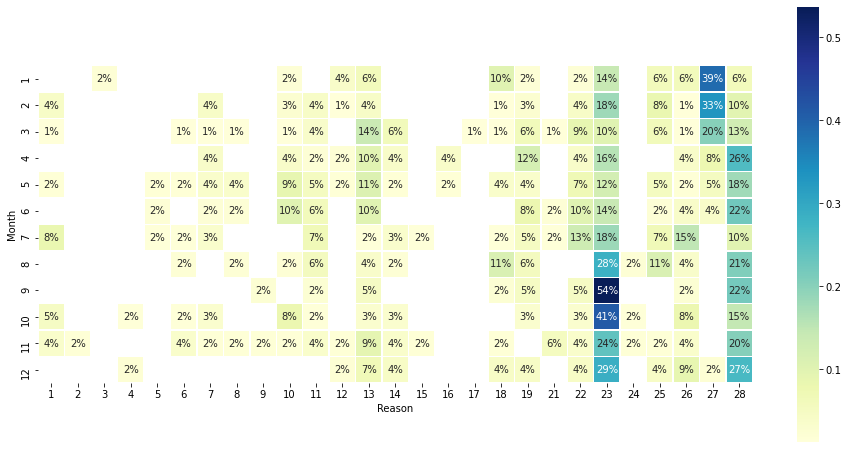

In [21]:
# Reason & Number
plt.figure(figsize=(16, 8))
data = absences.groupby(['Month', 'Reason']).apply(len) / absences.groupby('Month').apply(len)
data = data.unstack()
data = data.loc[:, sorted(data.columns)]
sns.heatmap(data, annot=True, cmap="YlGnBu", square=True, linewidths =.5, fmt='.0%');

## Time Series Forecasting -- Too few data to get interesting insight

### Feature Engineering 

In [22]:
# Add year
absences['Year'] = -1
year = 2007
new_year = (absences['Month'].shift(1) == 12) & (absences['Month'] == 1)
for ind, ny in zip(absences.index, new_year):
    year = year + 1 if ny else year
    absences.loc[ind, 'Year'] = year

### Time Serie Creation : Monthly Total Missed Hours

In [23]:
# Create Month Index Column
absences['MonthInd'] = absences['Year'].astype(str).str[:] + '-' + absences['Month'].astype(str).str.rjust(2, '0')
absences['MonthInd'] = pd.to_datetime(absences['MonthInd'])

# Create Time Serie
monthly_total = absences.groupby('MonthInd').sum()['AbsH']
monthly_total.index = monthly_total.index.to_period(freq='M')

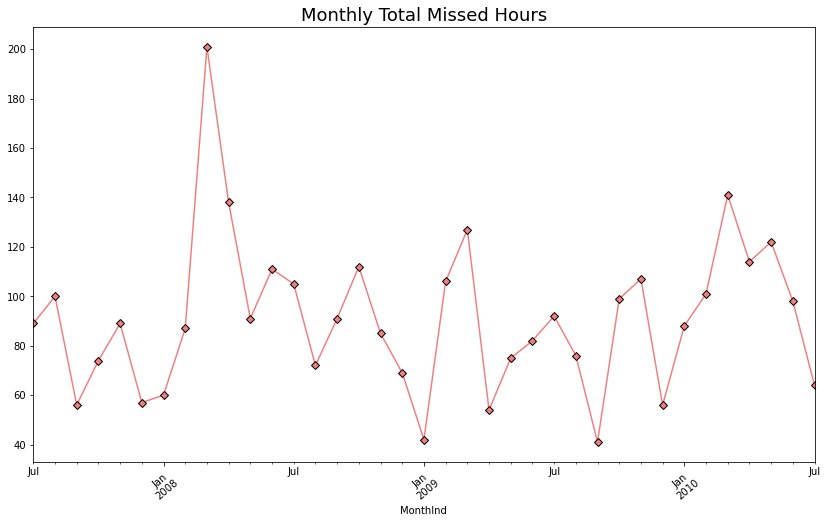

In [24]:
# Plot time series
plt.figure(figsize=(14, 8))
plt.title('Monthly Total Missed Hours', fontsize='18')
monthly_total.plot(style='-*', color='lightcoral', marker='D', markeredgecolor='black')
plt.xticks(rotation=40);

### Split Training / Testing Sets : 2 Years / 1 Year

In [25]:
# Split
y_train = monthly_total.iloc[:25]
y_test = monthly_total.iloc[25:]

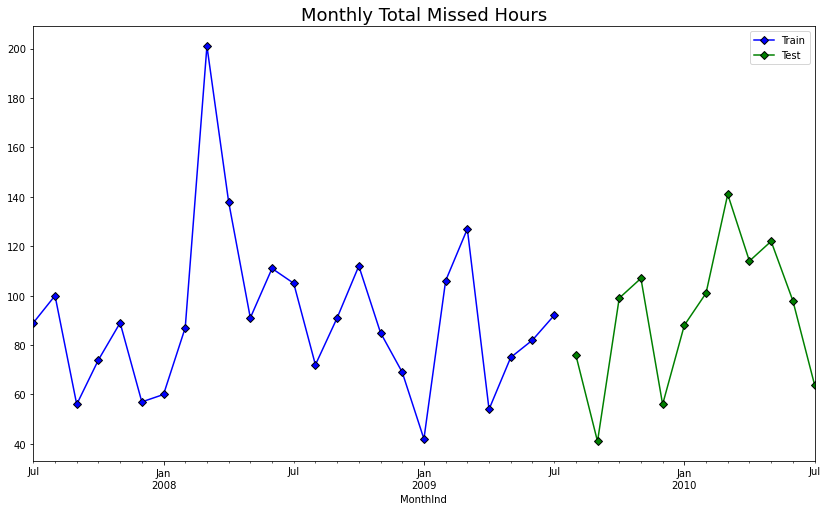

In [26]:
# Plot time series
plt.figure(figsize=(14, 8))
plt.title('Monthly Total Missed Hours', fontsize='18')
y_train.plot(style='-*', color='blue', marker='D', markeredgecolor='black', label='Train')
y_test.plot(style='-*', color='green', marker='D', markeredgecolor='black', label='Test')
plt.legend();

### Forecasting

In [27]:
# Dummy Model : Last Value
y_last_value = pd.Series(y_train.iloc[-1], index=y_test.index)
y_last_value

MonthInd
2009-08    92
2009-09    92
2009-10    92
2009-11    92
2009-12    92
2010-01    92
2010-02    92
2010-03    92
2010-04    92
2010-05    92
2010-06    92
2010-07    92
Freq: M, dtype: int64

In [28]:
# Dummy Model : Last Value Same Month
y_monthly_last_value = pd.Series(y_train.iloc[-12:].values,index=y_test.index)
y_monthly_last_value

MonthInd
2009-08     72
2009-09     91
2009-10    112
2009-11     85
2009-12     69
2010-01     42
2010-02    106
2010-03    127
2010-04     54
2010-05     75
2010-06     82
2010-07     92
Freq: M, dtype: int64

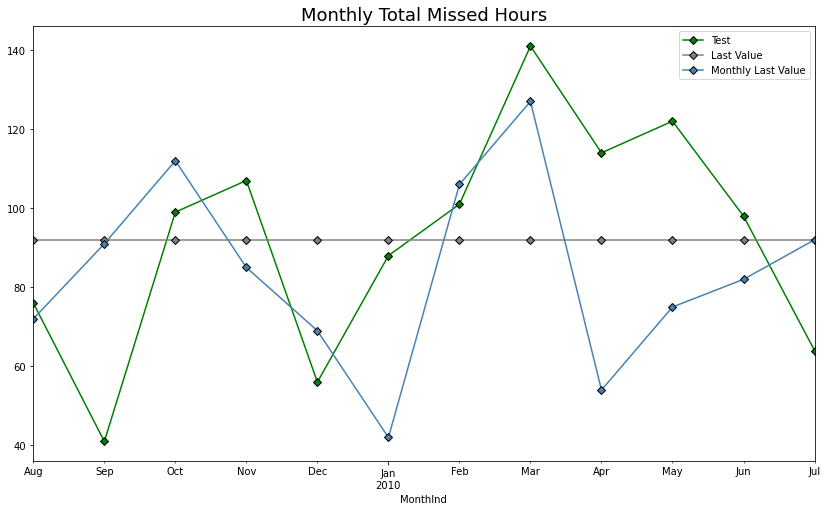

In [29]:
# Plot time series
plt.figure(figsize=(14, 8))
plt.title('Monthly Total Missed Hours', fontsize='18')
y_test.plot(style='-*', color='green', marker='D', markeredgecolor='black', label='Test')

y_last_value.plot(style='-*', color='grey', marker='D', markeredgecolor='black', label='Last Value')
y_monthly_last_value.plot(style='-*', color='steelblue', marker='D', markeredgecolor='black', label='Monthly Last Value')
plt.legend();